In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [300]:
class MLP(nn.Module):
    """
    Create a simple MLP
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            if (i < len(sizes) - 2):
                act = activation
            else:
                act = output_activation
            layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


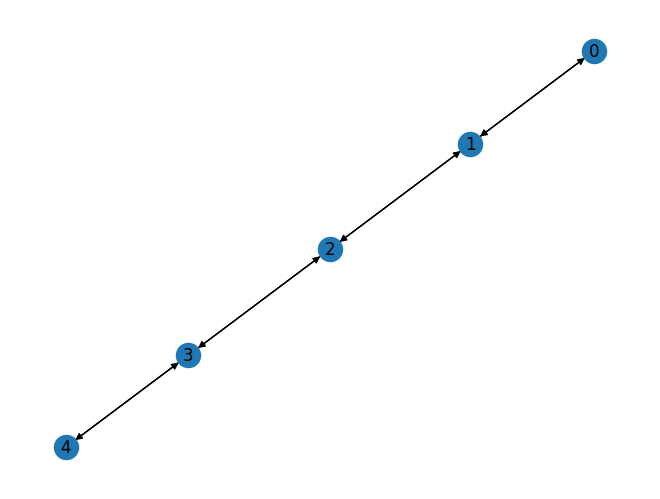

tensor([[0.5000, 0.0000, 0.4843],
        [1.5000, 0.0000, 0.0053],
        [2.5000, 0.0000, 0.1712],
        [3.5000, 0.0000, 0.2585],
        [4.5000, 0.0000, 0.0706]])


In [301]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph

def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    pos = torch.tensor(coordinates, dtype=torch.float)
    
    # Add the load as a node attribute
    load = torch.rand(pos.size(0), 1) * metadata["P_initial"]

    # Concat node features and load
    node_features = torch.cat([pos, load], dim=1)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(pos, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (pos[edge_index[1]] - pos[edge_index[0]])   
    
    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)
    
    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0.5,
"node_features": ["x", "y", "load"], "edge_features": ["distance", "displacement", "E_edge"],
"node_input_size": 3, "edge_input_size": 4}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.x)

In [302]:
# Import data
import pandas as pd

df = pd.read_json(r"C:\Users\kurt-\Documents\GitHub\dsa-2024\data\JSON_Data_Updated\n=100_p=1_varying_l_vectors.json")

In [303]:
np.array(df[1][0][0]) - np.array(df[1][0][1])

array([-0.1010101,  0.       ])

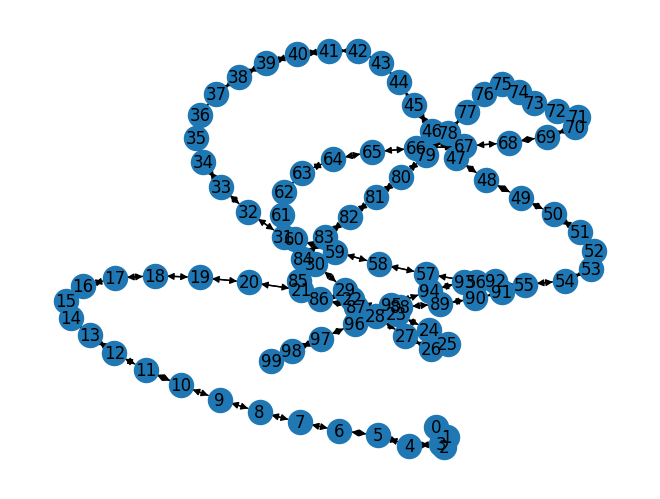

In [304]:
# Example usage with beam data

metadata["default_connectivity_radius"] = 0.1011
metadata["E_initial"] = 10
metadata["P_initial"] = 0.5

A  = create_gnn_graph(df[1][0], metadata)

graph = to_networkx(A)
nx.draw(graph, with_labels=True)
plt.show()

In [305]:
# Encoder
import torch
import torch.nn as nn
class Encoder(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim,):
        super().__init__()
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out), nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out), nn.LayerNorm(node_out)])

    def reset_parameters(self):
        self.mlp.reset_parameters()

    def forward(self, node_pos, edge_index, edge_attr):
        return self.node_fn(node_pos), self.edge_fn(edge_attr)


In [345]:
# Decoder
class Decoder(torch.nn.Module):
    def __init__(self, node_in, edge_in, mlp_num_layers, mlp_hidden_dim):
        super().__init__()
        # No LayerNorm in the decoder
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], 2)]) # Predicting load and displacement
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], 1)]) # Predicting E_edge

    def reset_parameters(self):
        self.mlp.reset_parameters()

    def forward(self, node_pos, edge_attr):
        out_node = self.node_fn(node_pos)
        out_edge = self.edge_fn(edge_attr)
        return out_node, out_edge

In [346]:
print(A.x.shape, A.edge_attr.shape)

torch.Size([100, 3]) torch.Size([198, 4])


In [349]:
node_in = metadata["node_input_size"]
node_out = 5
edge_in = metadata["edge_input_size"]
edge_out = 5
out_hidden_dim = 10
out_num_layers = 4
out_size = 1

mlp_num_layers = 4
mlp_hidden_dim = 10

encoder = Encoder(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
out1, out2 = encoder.forward(A.x, A.edge_index, A.edge_attr)
decoder = Decoder(node_out, edge_out, mlp_num_layers, mlp_hidden_dim)
out3, out4 = decoder.forward(out1, out2)


In [341]:
# Create a training process for the model

class BeamNN(nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim):
        super(BeamNN, self).__init__()
        self.encoder = Encoder(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
        self.decoder = Decoder(node_out, edge_out, mlp_num_layers, mlp_hidden_dim)

    def forward(self, node_pos, edge_index, edge_attr):
        node_out, edge_out = self.encoder(node_pos, edge_index, edge_attr)
        node_out, edge_out = self.decoder(node_out, edge_out)
        return node_out, edge_out

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.decoder.reset_parameters()



In [342]:
# Train
import torch.optim as optim
from torch_geometric.data import DataLoader

def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        node_out, edge_out = model(data.x, data.edge_index, data.edge_attr)
        loss = criterion(node_out, data.x) + criterion(edge_out, data.edge_attr)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [343]:
# Begin training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BeamNN(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
data_loader = DataLoader([df[1]], batch_size=1)

TypeError: Decoder.__init__() missing 4 required positional arguments: 'edge_out', 'out_num_layers', 'out_hidden_dim', and 'out_size'